In [1]:
import matplotlib.pyplot as plt
import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences
import numpy as np
import numpy.ma as ma  
import pandas as pd
import csv
import random
import seaborn as sns
from joblib import load
from sklearn.model_selection import train_test_split
import amp.data_utils.data_loader as data_loader
from amp.config import MIN_LENGTH, MAX_LENGTH
from amp.data_utils.sequence import pad, to_one_hot
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

seed = 7

sns.set_style('whitegrid', {'grid.color': '.95', 'axes.spines.right': False, 'axes.spines.top': False})

params = {'axes.labelsize': 9,'axes.titlesize':9, 'font.size': 9, 'legend.fontsize': 9, 'xtick.labelsize': 9, 'ytick.labelsize': 9}
plt.rcParams.update(params)

Using TensorFlow backend.


# Amino acid composition

In [2]:
models = [
    'HydrAMP',
    'PepCVAE',
    'Basic',
]

model_labels = [
    'hydramp',
    'pepcvae',
    'basic'
]

hydra_color = '#B80018'
pepcvae_color = '#1d3557'
basic_color = '#B4C5E4'

In [6]:
hydra_f = open('../../result/hydramp/case3_result.csv','r')
basic_f = open('../../result/basic/case3_result.csv','r')
pepcvae_f = open('../../result/pepcvae/case3_result.csv','r')

hydra_reader = csv.reader(hydra_f)
basic_reader = csv.reader(basic_f)
pepcvae_reader = csv.reader(pepcvae_f)
next(hydra_reader)
next(basic_reader)
next(pepcvae_reader)
prototype_list = []
hydra_list = []
hydra_zero_list = []
basic_list = []
basic_zero_list = []
pepcvae_list = []
pepcvae_zero_list = []

for row in hydra_reader:
    _, t = row[0].split('_')
    if t == 'original':
        prototype_list.append(row[1])
    if t == 'HydrampOpt':
        hydra_list.append(row[1])
    if t == 'HydrampZeroOpt':
        hydra_zero_list.append(row[1])

for row in basic_reader:
    _, t = row[0].split('_')
    if t == 'BasicOpt':
        basic_list.append(row[1])
    if t == 'BasicZeroOpt':
        basic_zero_list.append(row[1])

for row in pepcvae_reader:
    _, t = row[0].split('_')
    if t == 'PepCVAEOpt':
        pepcvae_list.append(row[1])
    if t == 'PepCVAEZeroOpt':
        pepcvae_zero_list.append(row[1])

hydra_f.close()
basic_f.close()
pepcvae_f.close()

In [4]:
def get_aa_composition(data):
    STD_AA = list('ACDEFGHIKLMNPQRSTVWY')
    seq = ''.join(data)
    count = len(seq)

    aa_comp = {}
    for aa in STD_AA:
        aa_comp[aa] = seq.count(aa) / count
    return aa_comp

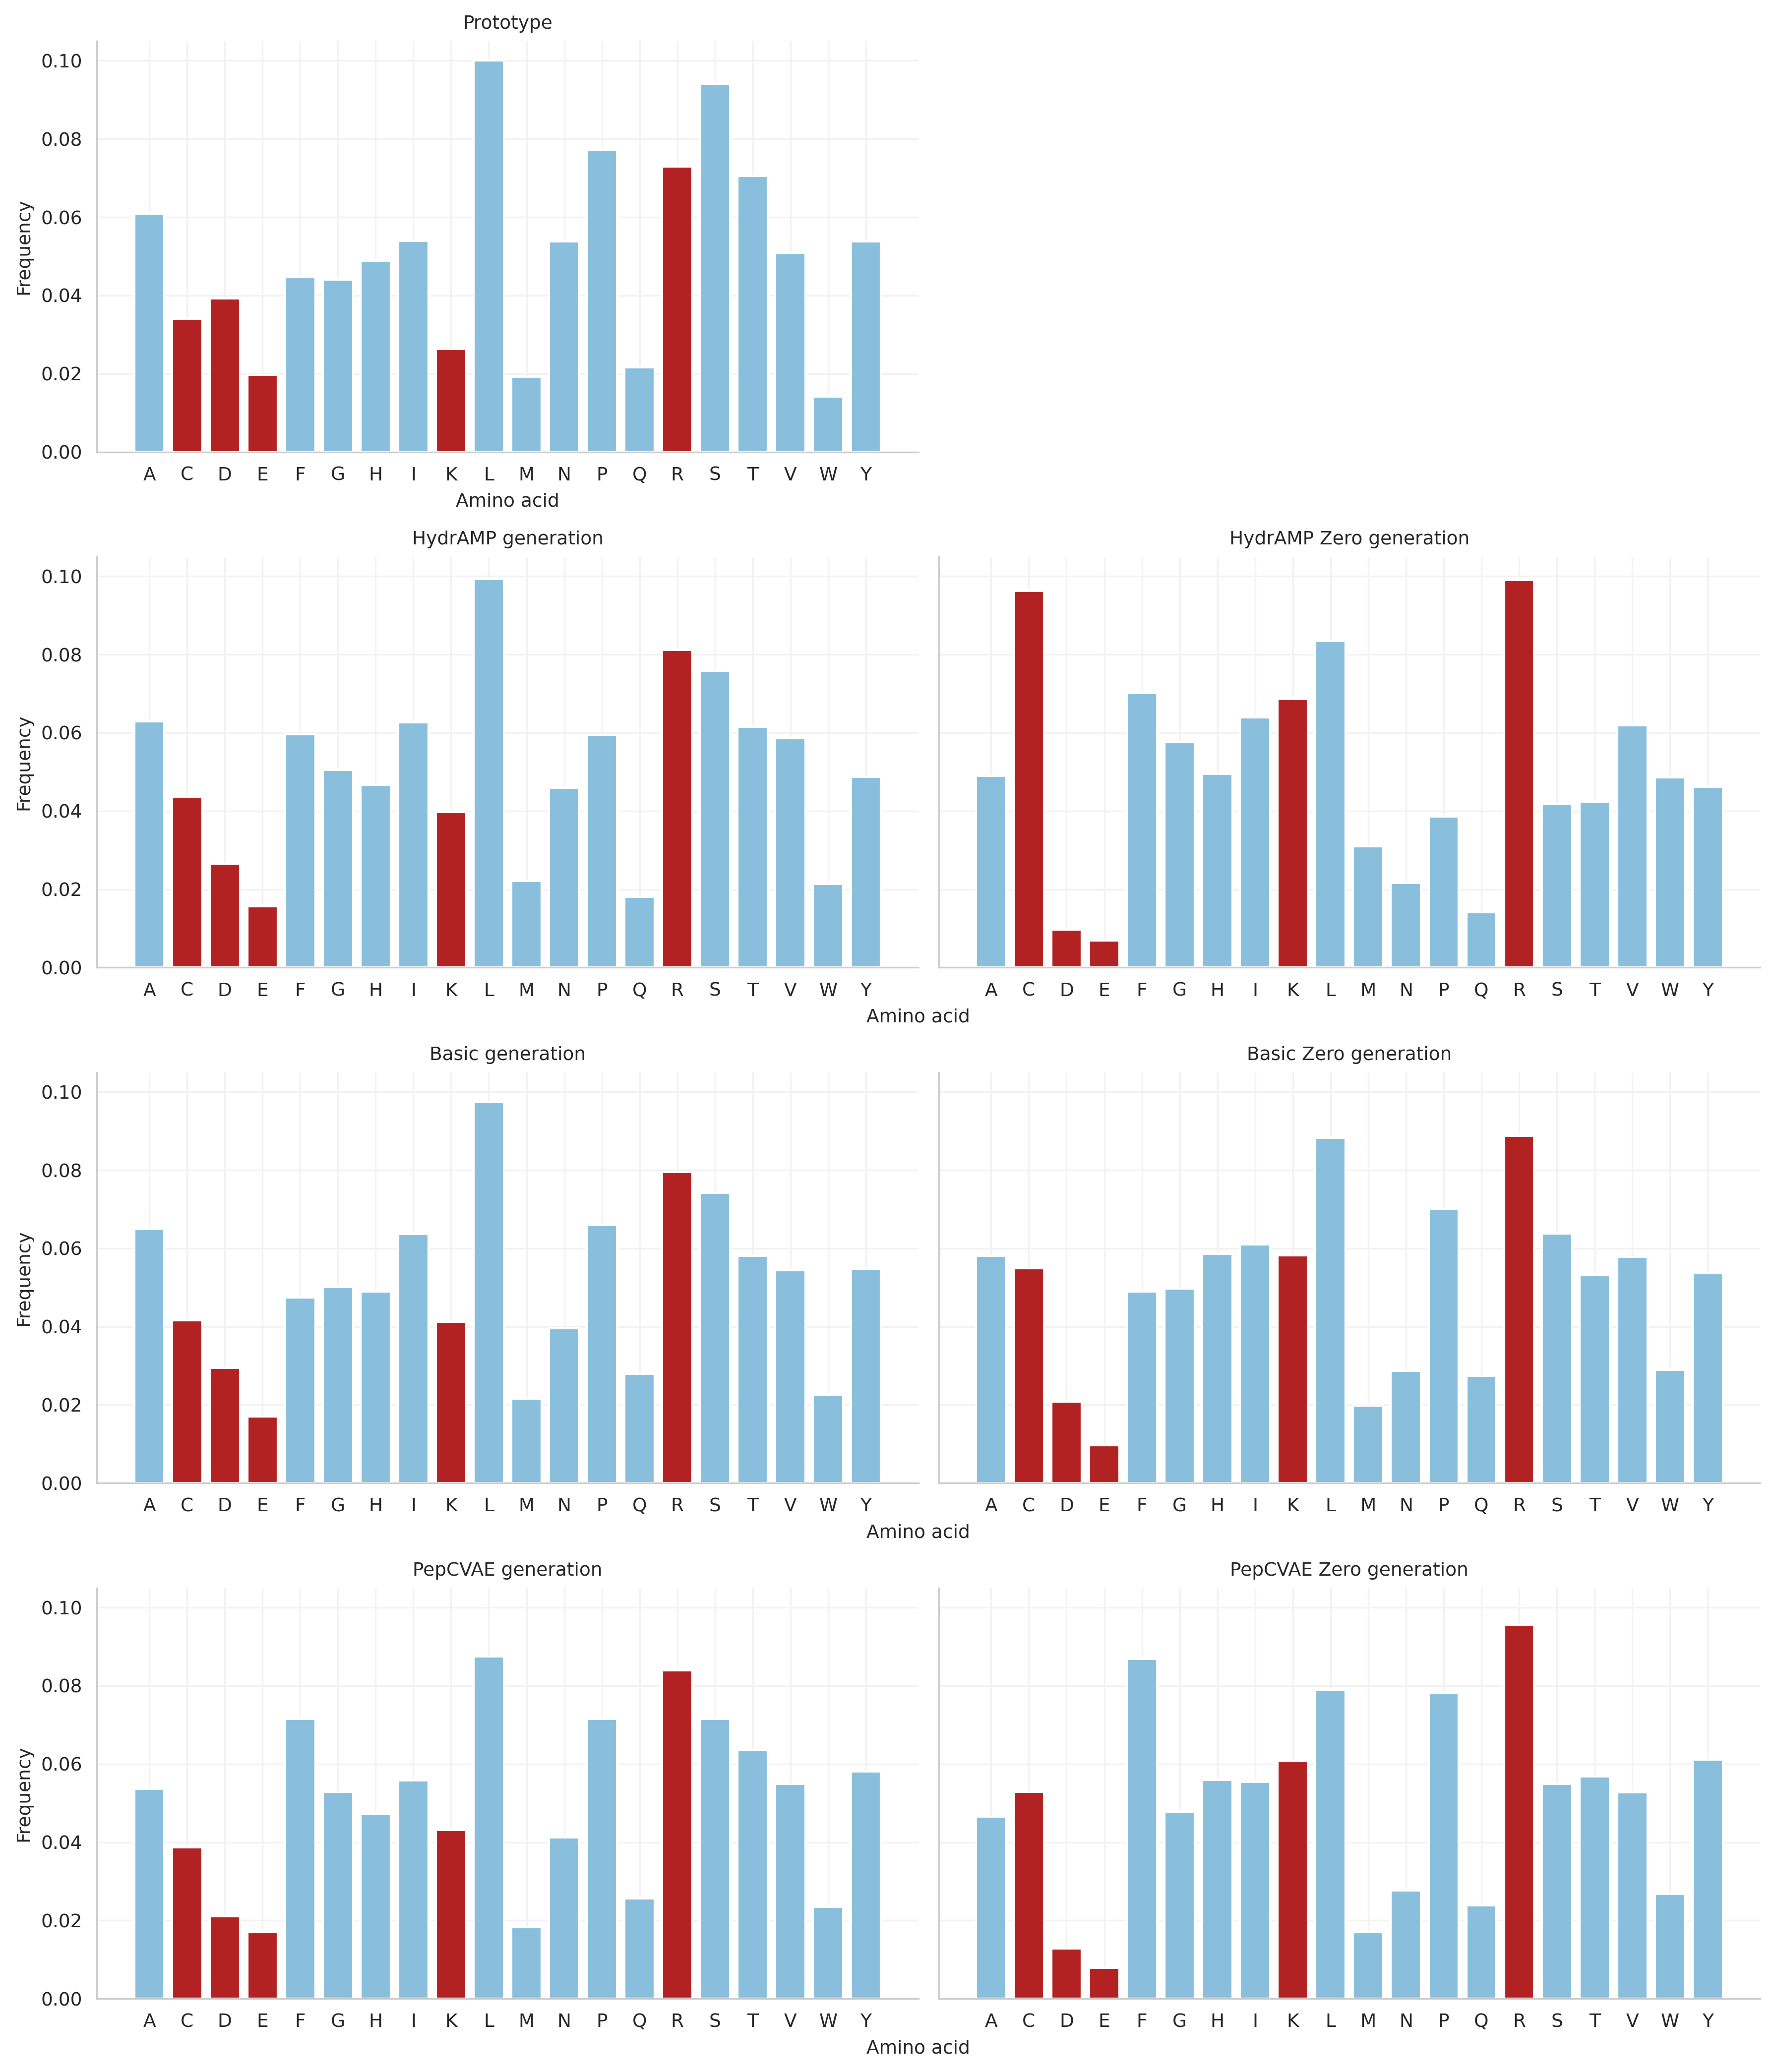

In [7]:
fig, ((ax1,ax1.dummy), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(
    nrows=4,
    ncols=2, 
    figsize=(12, 14), 
    dpi=300, 
    sharey=True,
    # gridspec_kw={'width_ratios': [1, 2, 2, 2]}
)
aa_dict = {}
ax1.dummy.remove()
for i, (ax, data, title) in enumerate(zip(
    [ax1, ax2, ax3, ax4, ax5, ax6, ax7],
    [prototype_list, hydra_list, hydra_zero_list, basic_list, basic_zero_list, pepcvae_list, pepcvae_zero_list],
    [
        'Prototype', 
        'HydrAMP generation', 
        'HydrAMP Zero generation', 
        'Basic generation', 
        'Basic Zero generation',
        'PepCVAE generation',
        'PepCVAE Zero generation'
    ]
    )):
    aa_composition = get_aa_composition(data)
    aa_dict[f'{title}'] = aa_composition
    clrs = ['firebrick' if (x in ['K', 'E', 'C', 'R', 'D']) else '#89bedc' for x in list(aa_composition.keys())]
    ax.bar(x=list(aa_composition.keys()), height=list(aa_composition.values()), color=clrs)
    ax.set_title(title)

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Amino acid', x=0.5)
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Amino acid', x=1)
ax4.set_ylabel('Frequency')
ax4.set_xlabel('Amino acid', x=1)
ax6.set_ylabel('Frequency')
ax6.set_xlabel('Amino acid', x=1)
fig.tight_layout()
plt.savefig('../figures/figure/case3_all_aacomposition.pdf')

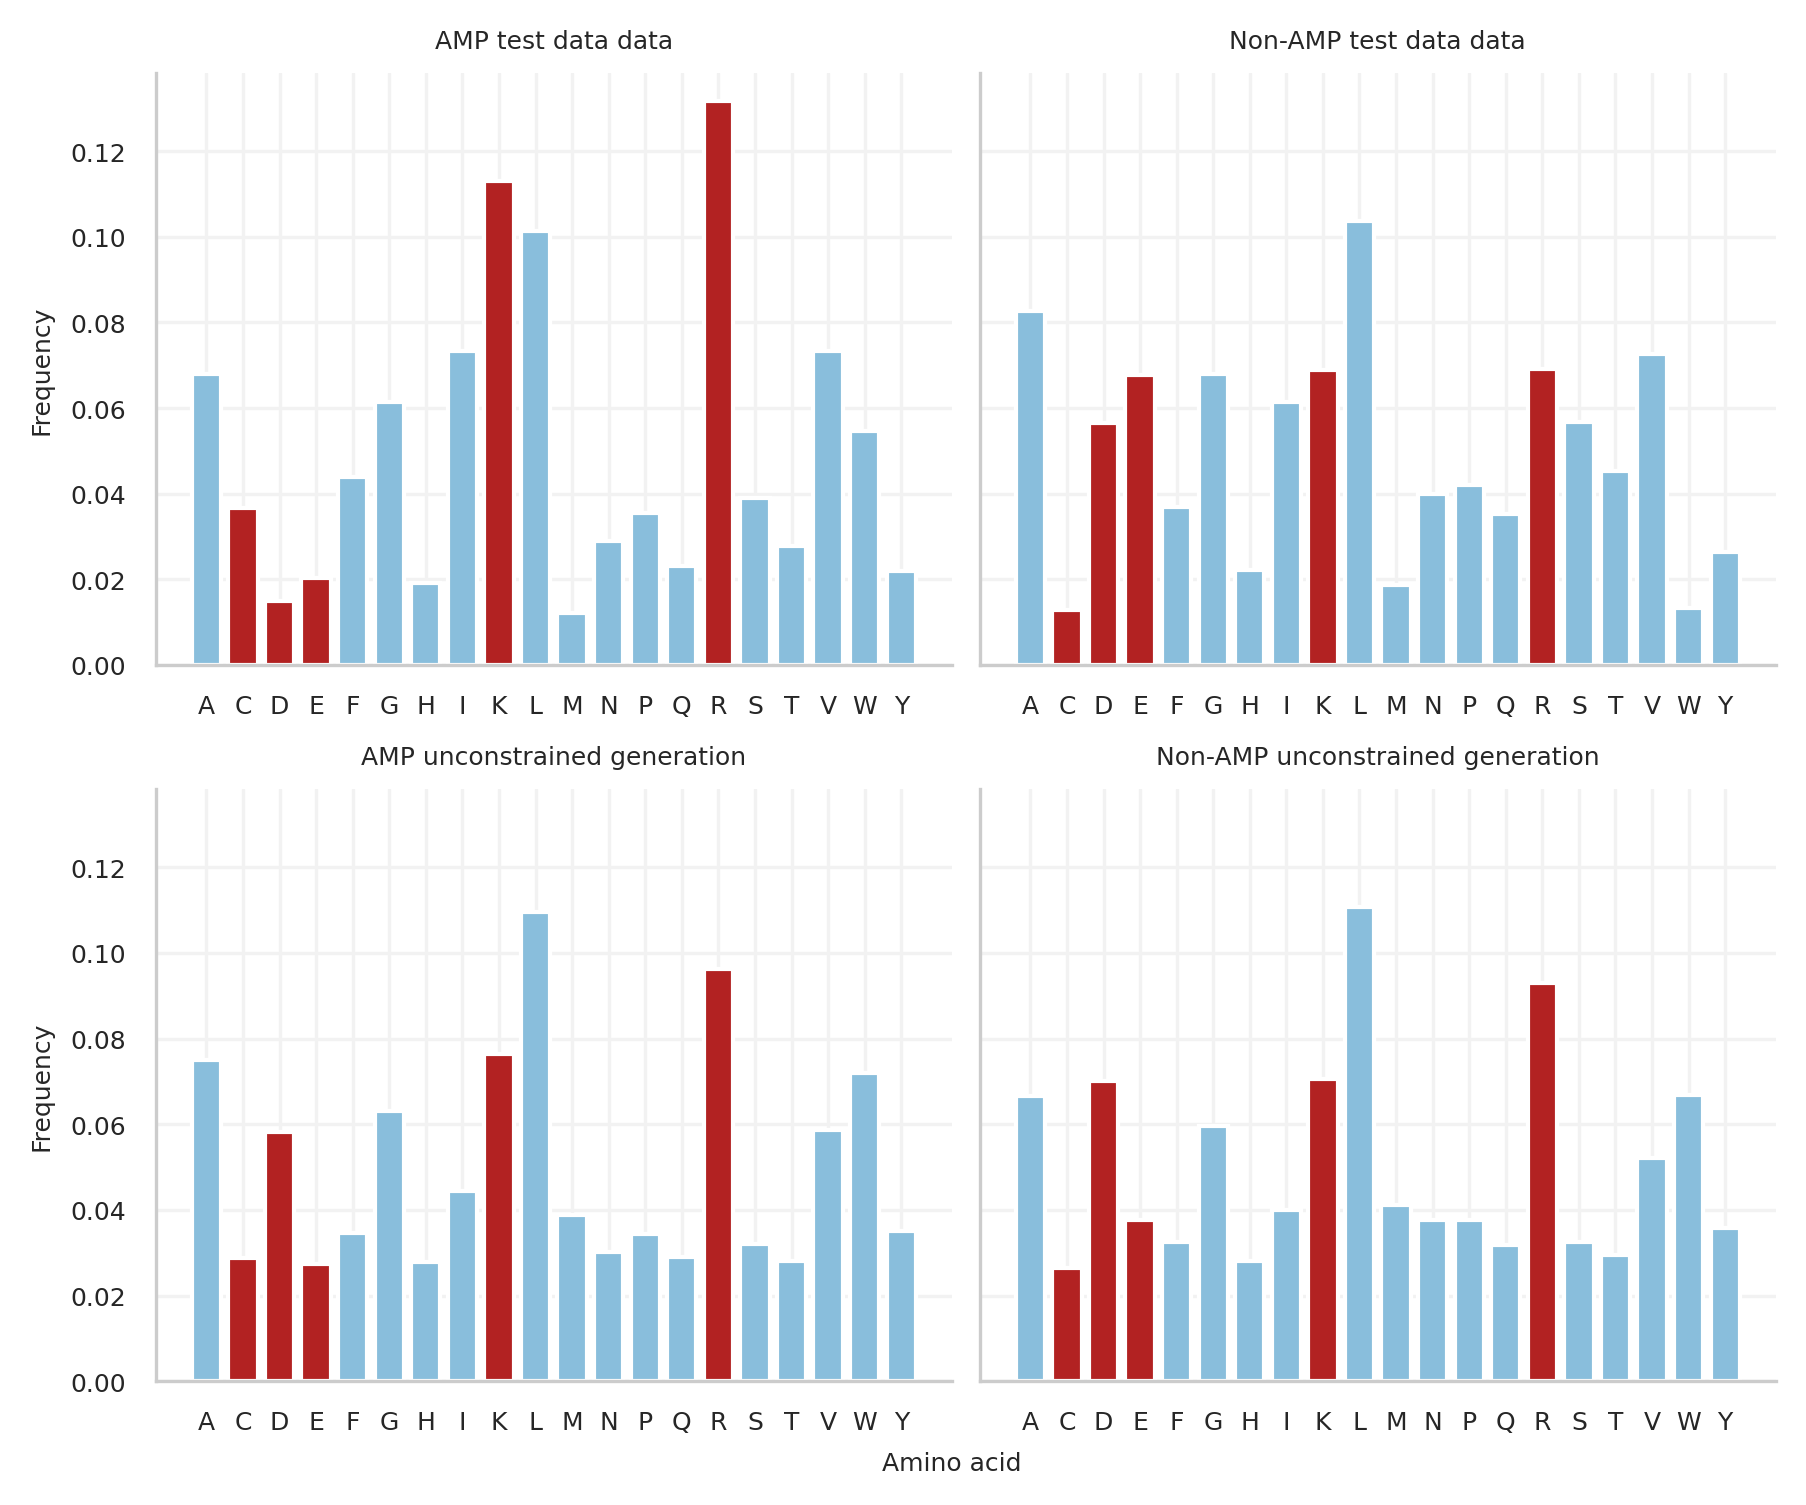

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(6,5), dpi=300, sharey='all')
aa_dict = {}
for i, (ax, data, title) in enumerate(zip(
    [ax1, ax2, ax3, ax4],
    [positives, negatives, basic_positives, basic_negatives],
    ['AMP test data data', 'Non-AMP test data data', 'AMP unconstrained generation', 'Non-AMP unconstrained generation']
    )):
    aa_composition = get_aa_composition(data)
    aa_dict[f'{title}'] = aa_composition
    clrs = ['firebrick' if (x in ['K', 'E', 'C', 'R', 'D']) else '#89bedc' for x in list(aa_composition.keys())]
    ax.bar(x=list(aa_composition.keys()), height=list(aa_composition.values()), color=clrs)
    ax.set_title(title)

ax1.set_ylabel('Frequency')
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Amino acid', x=1)
fig.tight_layout()
plt.savefig("Basic_SuppFig_aacomposition.svg")

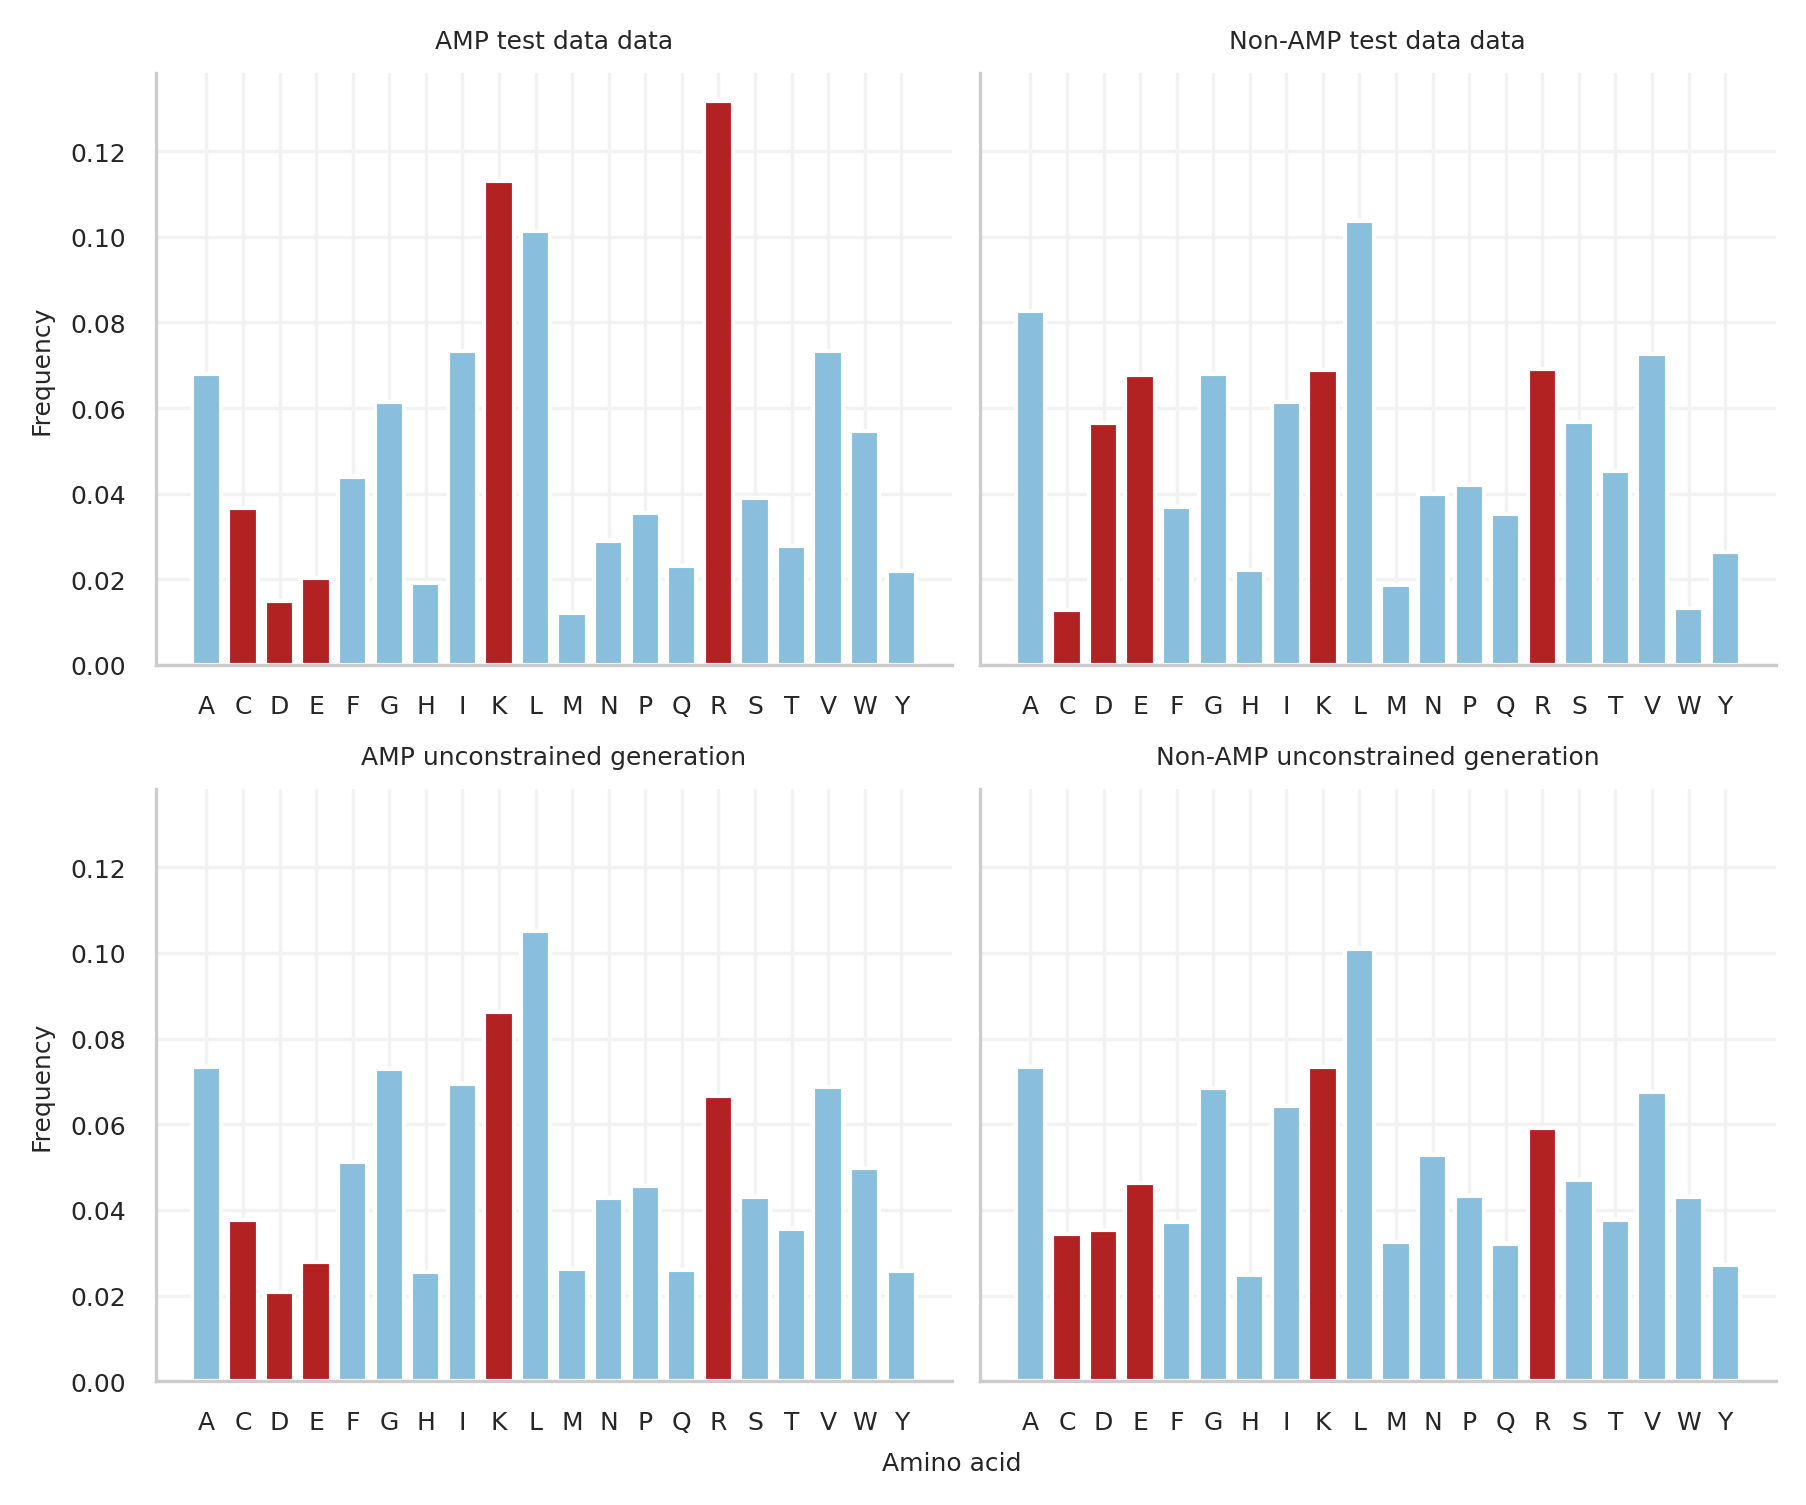

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(6,5), dpi=300, sharey='all')
aa_dict = {}
for i, (ax, data, title) in enumerate(zip(
    [ax1, ax2, ax3, ax4],
    [positives, negatives, pepcvae_positives, pepcvae_negatives],
    ['AMP test data data', 'Non-AMP test data data', 'AMP unconstrained generation', 'Non-AMP unconstrained generation']
    )):
    aa_composition = get_aa_composition(data)
    aa_dict[f'{title}'] = aa_composition
    clrs = ['firebrick' if (x in ['K', 'E', 'C', 'R', 'D']) else '#89bedc' for x in list(aa_composition.keys())]
    ax.bar(x=list(aa_composition.keys()), height=list(aa_composition.values()), color=clrs)
    ax.set_title(title)

ax1.set_ylabel('Frequency')
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Amino acid', x=1)
fig.tight_layout()
plt.savefig("PepCVAE_SuppFig_aacomposition.svg")

In [19]:
df = pd.DataFrame.from_dict(aa_dict)
df.to_csv('Supp_SourceData_FigureS2.csv')

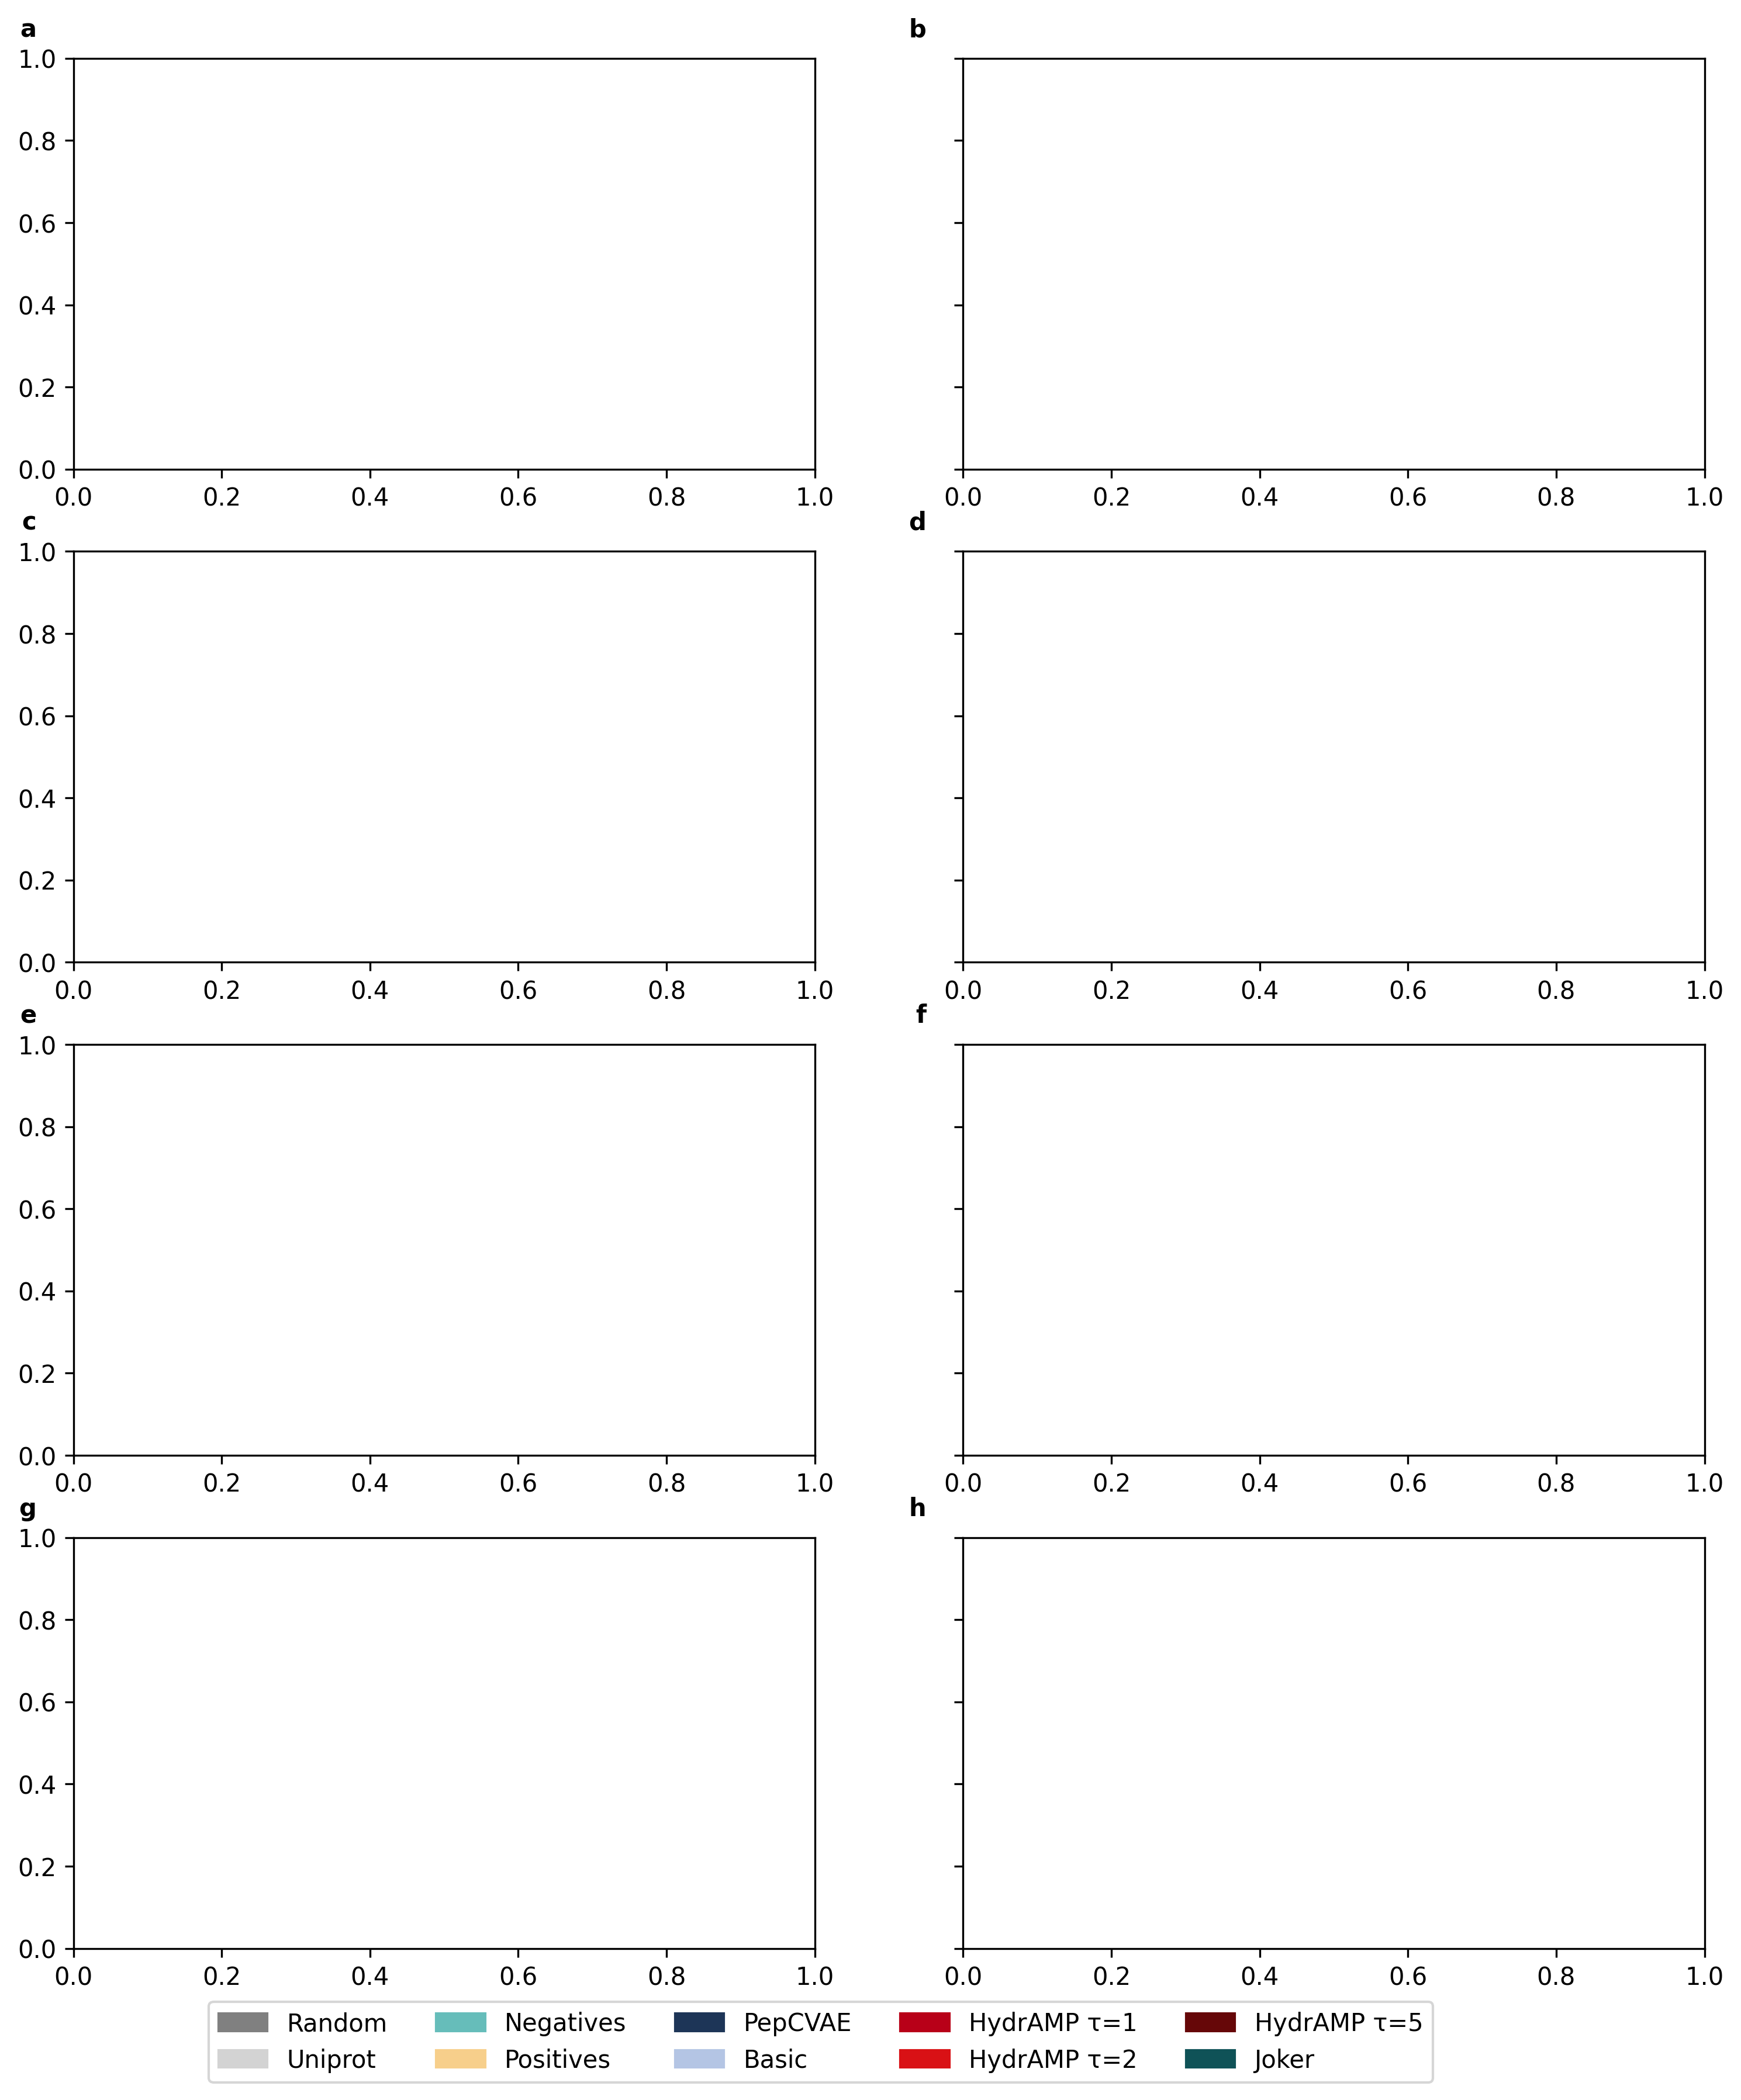

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

palette_models = {  
    'HydrAMP τ=1': '#B80018',
    'HydrAMP τ=2': '#D91115',
    'HydrAMP τ=5': '#660708',         
    'PepCVAE': '#1d3557',
    'Basic': '#B4C5E4',
    'Joker': '#0F5257'      
}
palette_0 = {
    'Random': 'grey', 
    'Uniprot': 'lightgray', 
    'Non-AMP test data': '#66BDBA',
    'AMP test data': '#F7CF8B',
}    
fig, ((ax1a,ax1b), (ax2a, ax2b), (ax3a, ax3b), (ax4a, ax4b)) = plt.subplots(
    nrows=4,
    ncols=2, 
    figsize=(12, 14), 
    dpi=300, 
    sharey=True,
)
for i, (label, ax) in enumerate(
zip(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'], [ax1a, ax1b, ax2a, ax2b, ax3a, ax3b, ax4a, ax4b])
):
    ax.annotate(label, xy=(-0.05, 1.1), xycoords='axes fraction',
        fontweight='bold', va='top', ha='right')

plt.legend(
    handles=[
        mpatches.Patch(color=palette_0['Random'], label='Random'),
        mpatches.Patch(color=palette_0['Uniprot'], label='Uniprot'),  
        mpatches.Patch(color=palette_0['Non-AMP test data'], label='Negatives'),  
        mpatches.Patch(color=palette_0['AMP test data'], label='Positives'),   
        mpatches.Patch(color=palette_models['PepCVAE'], label='PepCVAE'),
        mpatches.Patch(color=palette_models['Basic'], label='Basic'),          
        mpatches.Patch(color=palette_models['HydrAMP τ=1'], label='HydrAMP τ=1'),
        mpatches.Patch(color=palette_models['HydrAMP τ=2'], label='HydrAMP τ=2'),
        mpatches.Patch(color=palette_models['HydrAMP τ=5'], label='HydrAMP τ=5'),
        mpatches.Patch(color=palette_models['Joker'], label='Joker'),
        
    ], 
    bbox_to_anchor = (0.65, -0.1),
    ncol=5,
)